In [1]:
import ccxt
import pandas as pd
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
from stocktrends import Renko
import mplfinance as mpf
import warnings
warnings.filterwarnings("ignore")

In [20]:
def fetch_asset_data(symbol, start_date, interval, exchange):
    """
    Returns data as df
    Args:
        symbol: Asset pair (ETH, USDT)
        start_date: Start date of data
        interval: Interval it takes to generate a single candle
        exchange: Broker to fetch data from
    """
    # Convert start date to milliseconds stamp
    start_date_ms = exchange.parse8601(start_date)
    
    ohlcv = exchange.fetch_ohlcv(symbol, interval, since=start_date_ms)
    
    header = ["Date", "Open", "High", "Low", "Close", "Volume"]
    df = pd.DataFrame(ohlcv, columns=header)
    df['Date'] = pd.to_datetime(df['Date'], unit='ms')
    df.set_index('Date', inplace=True)
    return df

In [21]:
def renko_data(data):
    """
    Calculate the Renko chart data given the asset data
    """
    # For stable backtesting, the last row is dropped (Completed candles)
    data.drop(data.index[-1], inplace=True)
    
    data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'], 14)
    data.dropna(inplace=True)
    
    def evaluate_brick_size_atr(brick_size, atr_values):
        # Calculate number of bricks based on ATR size
        num_bricks = atr_values // brick_size
        return np.sum(num_bricks)

    # Get optimized brick size
    brick = opt.fminbound(lambda x: -evaluate_brick_size_atr(x, data['ATR']), np.min(data['ATR']), np.max(data['ATR']), disp=0)
    
    def custom_round(number):
        # List of available rounding values
        rounding_values = [0.001, 0.005, 0.01, 0.05,
                           0.1, 0.5, 1] + list(range(5, 100, 5))
        rounding_values += list(range(100, 1000, 50)) + \
            list(range(1000, 10000, 100))
        
        # Find the closest value to the number
        return min(rounding_values, key=lambda x: abs(x - number))

    brick_size = custom_round(brick)
    print(f"Optimized brick size: {brick_size}")
    data.reset_index(inplace=True)
    data.columns = [i.lower() for i in data.columns]
    df = Renko(data)
    df.brick_size = brick_size
    renko_df = df.get_ohlc_data()
    
    renko_df.rename(columns={'date': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    
    # Return the ohlc columns to floats
    renko_df['Open'] = renko_df['Open'].astype(float)
    renko_df['High'] = renko_df['High'].astype(float)
    renko_df['Low'] = renko_df['Low'].astype(float)
    renko_df['Close'] = renko_df['Close'].astype(float)
    
    return renko_df
    

In [28]:
def generate_positions(renko_df):
    # Rename the index of the renko data to brick
    renko_df.index.name = "brick"

    # Initialize signals list with 0 (no signal) for the first brick
    signals = []

    for i in range(0, len(renko_df)):
        # Get the current and previous brick colors
        is_current_green = renko_df['Close'].iloc[i] > renko_df['Open'].iloc[i]
        is_prev_green = renko_df['Close'].iloc[i -
                                               1] > renko_df['Open'].iloc[i - 1]

        if is_current_green and not is_prev_green:
            signals.append(1)  # Buy signal when the brick changes to green
        elif is_current_green and is_prev_green:
            signals.append(1)  # Hold signal when the brick remains green
        elif not is_current_green and is_prev_green:
            signals.append(-1)  # Sell signal when the brick changes to red
        elif not is_current_green and not is_prev_green:
            signals.append(-1)  # Hold signal when the brick remains red

     # Add the 'signals' column to the DataFrame
    renko_df['signals'] = signals
    renko_df['signals'] = renko_df["signals"].shift(1) #Remove look ahead bias
    renko_df.fillna(0.0, inplace=True)
    renko_df.set_index("Date", inplace=True)
    
    # Create the Positions
    # Initialize positions with nan
    renko_df['buy_positions'] = np.nan
    renko_df['sell_positions'] = np.nan
    
    renko_df.index.freq = pd.infer_freq(renko_df.index)
    
   # Update the buy_positions with the close price where the signal is 1 and the previous signal is not equal to the current signal
    buy_signal_indices = renko_df[(renko_df['signals'] == 1) & (renko_df['signals'] != renko_df['signals'].shift(1))].index
    renko_df.loc[buy_signal_indices, 'buy_positions'] = renko_df.loc[buy_signal_indices, 'Close']

    # Update the sell_positions with close price where the signal is -1 and the previous signal is not equal to the current signal
    sell_signal_indices = renko_df[(renko_df['signals'] == -1) & (renko_df['signals'] != renko_df['signals'].shift(1))].index
    renko_df.loc[sell_signal_indices, 'sell_positions'] = renko_df.loc[sell_signal_indices, 'Close']

    # Reset duplicate dates in the positions to nan, i.e where the previous date is equal to the current date
    renko_df.loc[renko_df.index == pd.Series(renko_df.index).shift(1), ['buy_positions', 'sell_positions']] = np.nan

    return renko_df


In [26]:
def calculate_strategy_performance(strategy_df, capital=100, leverage=1):
    # Initialize the performance variables
    cumulative_balance = capital
    investment = capital
    pl = 0
    max_drawdown = 0
    max_drawdown_percentage = 0

    # Lists to store intermediate values for calculating metrics
    balance_list = [capital]
    pnl_list = [0]
    investment_list = [capital]
    peak_balance = capital

    # Loop from the second row (index 1) of the DataFrame
    for index in range(1, len(strategy_df)):
        row = strategy_df.iloc[index]

        # Calculate P/L for each trade signal
        if row['signals'] == 1:
            pl = ((row['Close'] - row['Open']) / row['Open']) * \
                investment * leverage
        elif row['signals'] == -1:
            pl = ((row['Open'] - row['Close']) / row['Close']) * \
                investment * leverage
        else:
            pl = 0

        # Update the investment if there is a signal reversal
        if row['signals'] != strategy_df.iloc[index - 1]['signals']:
            investment = cumulative_balance

        # Calculate the new balance based on P/L and leverage
        cumulative_balance += pl

        # Update the investment list
        investment_list.append(investment)

        # Calculate the cumulative balance and add it to the DataFrame
        balance_list.append(cumulative_balance)

        # Calculate the overall P/L and add it to the DataFrame
        pnl_list.append(pl)

        # Calculate max drawdown
        drawdown = cumulative_balance - peak_balance
        if drawdown < max_drawdown:
            max_drawdown = drawdown
            max_drawdown_percentage = (max_drawdown / peak_balance) * 100

        # Update the peak balance
        if cumulative_balance > peak_balance:
            peak_balance = cumulative_balance

    # Add new columns to the DataFrame
    strategy_df['investment'] = investment_list
    strategy_df['cumulative_balance'] = balance_list
    strategy_df['pl'] = pnl_list
    strategy_df['cumPL'] = strategy_df['pl'].cumsum()

    # Calculate other performance metrics (replace with your calculations)
    overall_pl_percentage = (
        strategy_df['cumulative_balance'].iloc[-1] - capital) * 100 / capital
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - capital
    min_balance = min(strategy_df['cumulative_balance'])
    max_balance = max(strategy_df['cumulative_balance'])

    # Print the performance metrics
    print("Overall P/L: {:.2f}%".format(overall_pl_percentage))
    print("Overall P/L: {:.2f}".format(overall_pl))
    print("Min balance: {:.2f}".format(min_balance))
    print("Max balance: {:.2f}".format(max_balance))
    print("Maximum Drawdown: {:.2f}".format(max_drawdown))
    print("Maximum Drawdown %: {:.2f}%".format(max_drawdown_percentage))

    # Return the Strategy DataFrame
    return strategy_df

In [31]:
# Plot the Candlestick data, the buy and sell signal markers
def plot_candlestick(df):
    # Plot the candlestick chart
    mpf.plot(df, type='candle', style='charles', datetime_format='%Y-%m-%d', xrotation=20,
             title=str(symbol + ' Candlestick Chart'), ylabel='Price', xlabel='Date', scale_width_adjustment=dict(candle=2))

# Plot the Renko Data.
def plot_renko(renko_df):
    # Plot the Renko Chart
    adp = [mpf.make_addplot(renko_df['buy_positions'], type='scatter', marker='^', label= "Buy", markersize=80, color='#2cf651'),
      mpf.make_addplot(renko_df['sell_positions'], type='scatter', marker='v', label= "Sell", markersize=80, color='#f50100')
     ]
    mpf.plot(renko_df, addplot=adp, type='candle', style='charles', datetime_format='%Y-%m-%d', xrotation=20,
             title=str(symbol + ' Renko Chart'), ylabel='Price', xlabel='Date', scale_width_adjustment=dict(candle=2))

# Plot the performance curve
def plot_performance_curve(strategy_df):
    # Plot the performance curve
    plt.plot(strategy_df['cumulative_balance'])
    plt.title('Performance Curve')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.xticks(rotation=70)
    plt.show()

                        Open     High      Low    Close      Volume
Date                                                               
2024-02-04 04:00:00  2300.89  2302.74  2289.12  2290.87   19.720784
2024-02-04 08:00:00  2291.45  2309.19  2287.08  2307.43   29.779717
2024-02-04 12:00:00  2306.95  2309.47  2298.02  2301.86   27.472762
2024-02-04 16:00:00  2301.59  2308.13  2267.59  2279.73  456.410332
2024-02-04 20:00:00  2279.73  2310.51  2274.40  2290.00  172.099678
...                      ...      ...      ...      ...         ...
2024-06-02 08:00:00  3793.41  3805.30  3773.59  3805.00   46.389758
2024-06-02 12:00:00  3806.25  3809.45  3779.98  3797.86   60.902218
2024-06-02 16:00:00  3803.24  3803.40  3753.12  3781.46  114.615744
2024-06-02 20:00:00  3781.46  3794.92  3766.90  3783.10   31.563438
2024-06-03 00:00:00  3780.90  3799.21  3765.00  3798.93   13.024945

[720 rows x 5 columns]


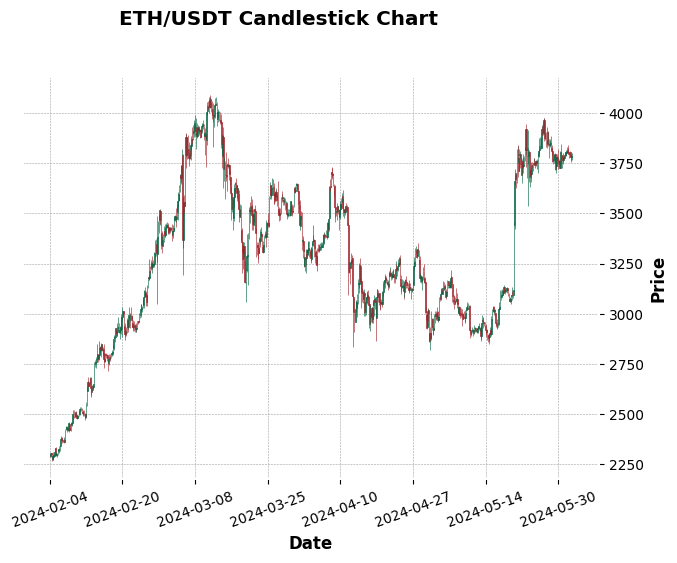

Optimized brick size: 25
                    Date    Open    High     Low   Close  uptrend
0    2024-02-06 12:00:00  2300.0  2325.0  2300.0  2325.0     True
1    2024-02-06 16:00:00  2325.0  2350.0  2325.0  2350.0     True
2    2024-02-06 16:00:00  2350.0  2375.0  2350.0  2375.0     True
3    2024-02-07 16:00:00  2375.0  2400.0  2375.0  2400.0     True
4    2024-02-08 00:00:00  2400.0  2425.0  2400.0  2425.0     True
..                   ...     ...     ...     ...     ...      ...
477  2024-05-30 04:00:00  3750.0  3750.0  3725.0  3725.0    False
478  2024-05-30 12:00:00  3750.0  3775.0  3750.0  3775.0     True
479  2024-05-31 08:00:00  3775.0  3800.0  3775.0  3800.0     True
480  2024-05-31 12:00:00  3775.0  3775.0  3750.0  3750.0    False
481  2024-06-01 12:00:00  3775.0  3800.0  3775.0  3800.0     True

[482 rows x 6 columns]
                       Open    High     Low   Close  uptrend  signals  \
Date                                                                    
2024-02-06 12

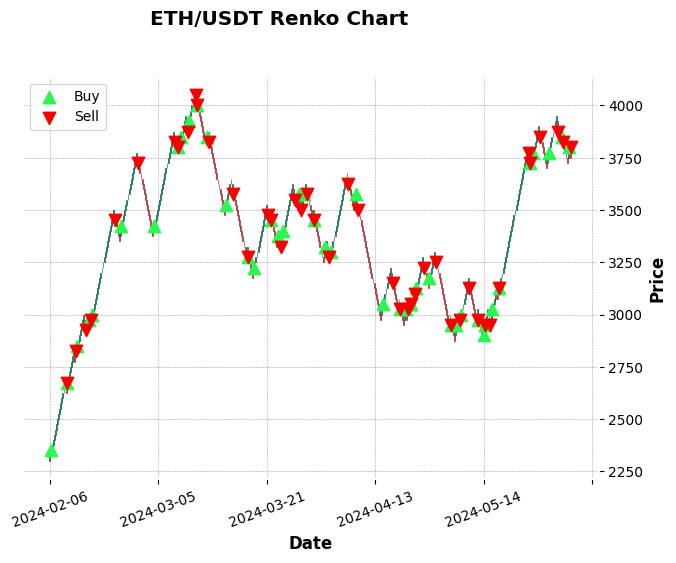

Overall P/L: 794.82%
Overall P/L: 794.82
Min balance: 100.00
Max balance: 906.71
Maximum Drawdown: -16.56
Maximum Drawdown %: -2.50%
                       Open    High     Low   Close  uptrend  signals  \
Date                                                                    
2024-02-06 12:00:00  2300.0  2325.0  2300.0  2325.0     True      0.0   
2024-02-06 16:00:00  2325.0  2350.0  2325.0  2350.0     True      1.0   
2024-02-06 16:00:00  2350.0  2375.0  2350.0  2375.0     True      1.0   
2024-02-07 16:00:00  2375.0  2400.0  2375.0  2400.0     True      1.0   
2024-02-08 00:00:00  2400.0  2425.0  2400.0  2425.0     True      1.0   
...                     ...     ...     ...     ...      ...      ...   
2024-05-30 04:00:00  3750.0  3750.0  3725.0  3725.0    False     -1.0   
2024-05-30 12:00:00  3750.0  3775.0  3750.0  3775.0     True     -1.0   
2024-05-31 08:00:00  3775.0  3800.0  3775.0  3800.0     True      1.0   
2024-05-31 12:00:00  3775.0  3775.0  3750.0  3750.0    False    

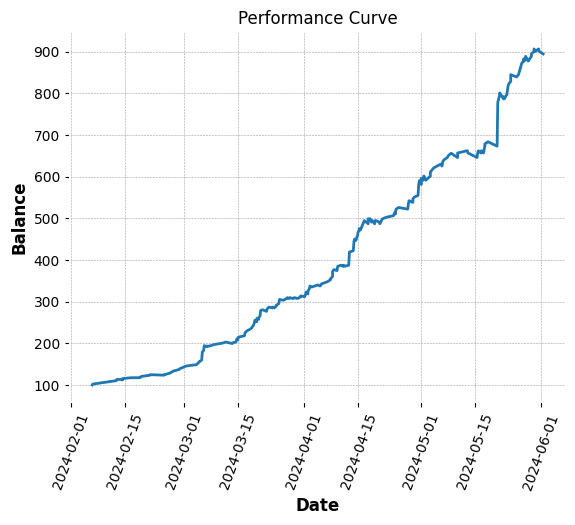

In [34]:
# Define the symbol, start date, interval and exchange
symbol = "ETH/USDT"
start_date = "2010-12-1"
interval = '4h'
exchange = ccxt.kraken()

# Fetch the historical data and Convert the data to a Pandas dataframe
data = fetch_asset_data(symbol=symbol, start_date=start_date, interval=interval, exchange=exchange)

# Print the asset dataframe
print(data)

# Plot the Symbol data candlestick chart
plot_candlestick(df=data)

# Get the Renko Bricks
renko_df = renko_data(data)
print(renko_df)

# Generate Strategy Signals
positions_df = generate_positions(renko_df)
print(positions_df)

# Plot the Renko Bricks and Positions
plot_renko(renko_df)

# Calculate Strategy Performance
strategy_df = calculate_strategy_performance(positions_df)
print(strategy_df)

# Plot the performance curve
plot_performance_curve(strategy_df)